## Homework 8 - Group 1
### Iwan Pasveer, Flavia Leotta, Noah Frinking, Dylan Gavron

Python version (3.12.6)


### Required libraries

In [9]:
import random
import networkx as nx
import matplotlib.pyplot as plt

### Seed

In [10]:
random.seed(15)

### Homework 8.1

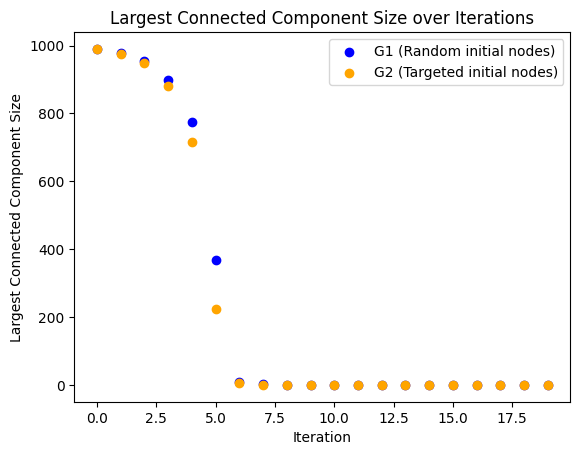

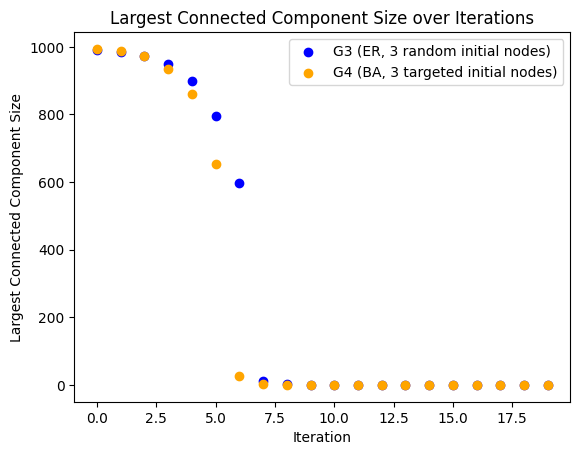

In [11]:
######################################## 8.1.1 ##############################################
def fail_attack(graph, initial_attack_list, time_steps, first_step = True, largest_component_size = None):
    """
    Simulates an attack strategy to fail a network that has all nodes in an active state.

    Args: 
        graph: a networkx graph
        initial_attack_list: list of nodes that are inactivated and that start the attack
        time_steps: number of iterations of the attack
        first_step: Boolean that marks if the function is called for the first time or not
        largest_component_size: list that keeps track of the size of the Largest Connected Component at every iteration

    Returns:
        the graph after the attack and the list largest_component_size
    """
    
    
    if largest_component_size is None:
        largest_component_size = []
    
    # We assume that all nodes in the graph are initially active with 'state' == 1.
    if first_step:
        for potential_node in graph.nodes():
            if potential_node in initial_attack_list:
                # Activate all nodes in the attack list
                graph.nodes[potential_node]['state'] = '0'
            else:
                # Initialize all the others
                graph.nodes[potential_node]['state'] = '1'
    
    if time_steps == 0:
        # Stop if there are no more time_steps available
        return graph, largest_component_size
    
    

    for node in initial_attack_list:
        candidates = [n for n in graph.neighbors(node) if graph.nodes[n]['state']=='1']
        
        if candidates:
            max_degree = max([graph.degree(candidate) for candidate in candidates])
            max_degree_nodes = [candidate for candidate in candidates if graph.degree(candidate) == max_degree]

            # If there are more than one node with the max degree, it chooses one randomly. 
            # Else, although the random choice is still called, only one node can be chosen
            node_to_attack = random.choice(max_degree_nodes)
            graph.nodes[node_to_attack]['state'] = '0'
    

    # We assume we can still consider the "old" inactive nodes if they still have active neighbours
    new_list = []
    for node in graph.nodes():
        if graph.nodes[node]['state'] == '0':
            if [n for n in graph.neighbors(node) if graph.nodes[n]['state']=='1']:
                new_list.append(node)

    active_nodes = [node for node in graph.nodes() if graph.nodes[node]['state'] == '1']
    if active_nodes:
        largest_component_size.append(len(max(nx.connected_components(graph.subgraph(active_nodes)), key=len)))
    else:
        largest_component_size.append(0)

    if new_list:
        return fail_attack(graph, new_list, time_steps - 1, first_step = False, largest_component_size = largest_component_size)
    else:
        while len(largest_component_size) < time_steps:
            largest_component_size.append(largest_component_size[-1])
        return graph, largest_component_size


######################################## 8.1.2 ##############################################
# We assume that by m = 3, the homework means 3 new edges created at every interaction (this will be relevant later).
random.seed(15)

G1 = nx.barabasi_albert_graph(1000,3)
initial_attack_list_G1 = random.sample(list(G1.nodes()), 5)

G2 = nx.barabasi_albert_graph(1000,3)
top5= sorted(G2.degree(), key=lambda x: x[1], reverse=True)[:5]
top5_nodes = [node for node, _ in top5]

attacked_G1, G1_largest = fail_attack(G1, initial_attack_list_G1, 20)
attacked_G2, G2_largest = fail_attack(G2, top5_nodes, 20)

while len(G1_largest) < 20:
    G1_largest.append(G1_largest[-1])
while len(G2_largest) < 20:
    G2_largest.append(G2_largest[-1])

plt.scatter(range(20), G1_largest, label='G1 (Random initial nodes)', color='blue')
plt.scatter(range(20), G2_largest, label='G2 (Targeted initial nodes)', color='orange')

plt.xlabel("Iteration")
plt.ylabel("Largest Connected Component Size")
plt.title("Largest Connected Component Size over Iterations")
plt.legend()
plt.show()



######################################## 8.1.3 ##############################################
# We assume that by m = 3000, the homework means the total number of edges. We have to assume this because, if every node has to form 3000 edges,
# we would need self loops and multi-edges.
random.seed(15)

G3 = nx.gnm_random_graph(1000, 3000)
initial_attack_list_G3 = random.sample(list(G3.nodes()), 3)

G4 = nx.barabasi_albert_graph(1000, 3)
while G4.number_of_edges() > 3000:
    G4.remove_edge(*random.choice(list(G4.edges())))
top3= sorted(G4.degree(), key=lambda x: x[1], reverse=True)[:3]
top3_nodes = [node for node, _ in top3]

attacked_G3, G3_largest = fail_attack(G3, initial_attack_list_G3, 20)
attacked_G4, G4_largest = fail_attack(G4, top3_nodes, 20)

while len(G3_largest) < 20:
    G3_largest.append(G3_largest[-1])
while len(G4_largest) < 20:
    G4_largest.append(G4_largest[-1])


plt.scatter(range(20), G3_largest, label='G3 (ER, 3 random initial nodes)', color='blue')
plt.scatter(range(20), G4_largest, label='G4 (BA, 3 targeted initial nodes)', color='orange')

plt.xlabel("Iteration")
plt.ylabel("Largest Connected Component Size")
plt.title("Largest Connected Component Size over Iterations")
plt.legend()
plt.show()


### Homework 8.2

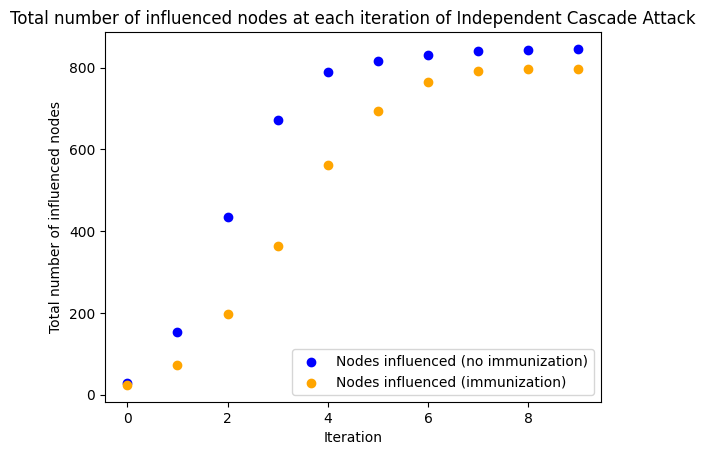

In [12]:
def InitializingState(graph, propagator=[]):
    """
    Initializes the state of the nodes in a Networkx graph.

    Args:
        graph: networkx graph
        propagator: the initial infected nodes

    Return:
        an initialized graph in which the nodes are either infected or susceptible
    """

    for node in graph.nodes:
        if propagator:
            if node in propagator:
                graph.nodes[node]['state'] = 'infected'
            else:
                graph.nodes[node]['state'] = 'susceptible'
        else:
            graph.nodes[node]['state'] = 'susceptible'
    
    return graph

def immunize_k(graph, initial_propagator, k):
    """
    Immunizes nodes in a graph, by setting their state to 'immune'.

    Args:
        graph: a graph created with Networkx
        initial_propagator: a list of nodes that start the infection
        k: the number of nodes you want to immunize, given that they're at a distance lower than 3 from the initial nodes

    Returns:
        a graph with immunized nodes.
    """
    N = set()

    for node in initial_propagator:
        subgraph = nx.ego_graph(graph, node, radius=3)
        N.update(subgraph.nodes)
    
    N -= set(initial_propagator)
    N = list(N)
    
    topk = sorted(N, key=lambda node: graph.degree(node), reverse=True)[:k]
    
    for node in topk:
        graph.nodes[node]['state'] = 'immune'
    return graph
        


def IndependentCascade(graph, propagator, p, iterations, influenced_nodes = None, first_iteration = True):
    """
    Simulate the Independent Cascade Model on a graph. If you want to have immune nodes, make sure
    to call the function immunize_k(graph, initial_propagator, k) before this one.

    Args:
        graph: A graph created with Networkx
        propagator: a list containing the nodes that start the infection
        p: influence probability. The default is 0.4
        iterations: maximum number of iterations. The default is 10
        influenced_nodes: keeps track of the total number of nodes influenced until each iteration
        first_iteration: Boolean that checks if the function is called for the first time

    Returns:
        an updated graph with the nodes state after the attack. The nodes state can be:
            - immune
            - infected 
            - susceptible
    """
    
    if influenced_nodes is None:
        influenced_nodes = []
    
    if iterations == 0 or not propagator:
        return graph, influenced_nodes
    

    if first_iteration:
        count_influenced_nodes = len(propagator)
    else:
        count_influenced_nodes = influenced_nodes[-1]
    
    
    next_propagator = set()

    for node in propagator:
        candidates = [n for n in graph.neighbors(node) if graph.nodes[n]['state'] == 'susceptible']
        for candidate in candidates:
            if random.random() < p:
                graph.nodes[candidate]['state'] = 'infected'
                next_propagator.add(candidate)
                count_influenced_nodes += 1
    
    influenced_nodes.append(count_influenced_nodes)
    

    return IndependentCascade(graph, next_propagator, p, iterations - 1, influenced_nodes, first_iteration=False)

random.seed(15)

G5 = nx.barabasi_albert_graph(1000, 3)
initial_propagator = random.sample(list(G5.nodes()), 10)

# Initialize the graph
G5 = InitializingState(G5, initial_propagator)

# IMMUNIZATION
G5_immunized = immunize_k(G5.copy(), initial_propagator, 10)

# Run Independent Cascade without Immunization
after_attack_G5, influenced_G5 = IndependentCascade(G5, initial_propagator, 0.4, iterations=10)

# Run Independent Cascade with Immunization
after_attack_G5_immunized, influenced_G5_immunized = IndependentCascade(G5_immunized, initial_propagator, 0.4, iterations=10)

plt.scatter(range(len(influenced_G5)), influenced_G5, label='Nodes influenced (no immunization)', color='blue')
plt.scatter(range(len(influenced_G5_immunized)), influenced_G5_immunized, label='Nodes influenced (immunization)', color='orange')

plt.xlabel("Iteration")
plt.ylabel("Total number of influenced nodes")
plt.title("Total number of influenced nodes at each iteration of Independent Cascade Attack")
plt.legend()
plt.show()
    
    
    

### Homework 8.3

Initial infected nodes for disease 1 (with degrees):
Node: 0, Degree: 59
Node: 1, Degree: 58
Node: 2, Degree: 35
Node: 3, Degree: 25
Node: 4, Degree: 107

Initial infected nodes for disease 2 (with degrees):
Node: 7, Degree: 68
Node: 5, Degree: 63
Node: 6, Degree: 55
Node: 16, Degree: 42
Node: 51, Degree: 35


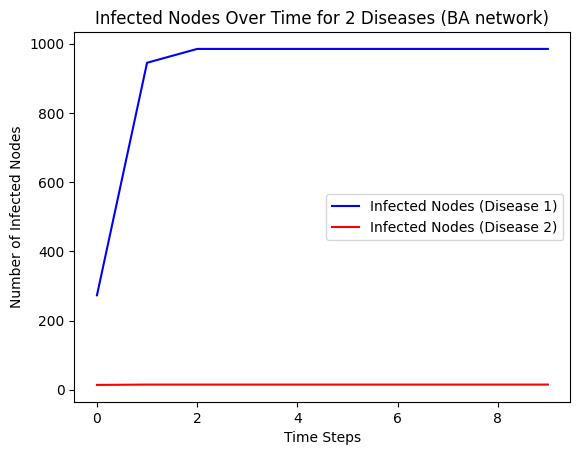

In [43]:
######################################## 8.3.1 ##############################################
def Competitive_Linear_Threshold(G, initial_infected_nodes_1, initial_infected_nodes_2, threshold_1, threshold_2, time_steps, information_1 = None, information_2 = None, first_iteration = True):
    """
    Simulates the spread of two "diseases" using the competitive linear threshold model.

    Args:
        G: a networkx graph
        initial_infected_nodes_1: initial nodes infected with the first disease
        initial_infected_nodes_2: initial nodes infected with the second disease
        threshold_1: the fraction of neighbours infected with the first disease for a new node to be infected with it
        threshold_2: the fraction of neighbours infected with the second disease for a new node to be infected with it
        time_steps: sets the number of iterations
        information_1: a list that keeps track of how many nodes are infected with the first disease at each time step
        information_2: a list that keeps track of how many nodes are infected with the second disease at each time step
        first_iteration: Boolean value that indicates if the function is called for the first time or not

    Returns:
        Three elements: the graph after the attack and the two lists information_1 and information_2.
    """
    
    
    
    def Initialize_2_diseases(graph, initial_infected_nodes_1, initial_infected_nodes_2):
        """
        Initializes the graph with the infected nodes given.

        Args:
            graph: a networkx graph
            initial_infected_nodes_1: initial nodes infected with the first disease
            initial_infected_nodes_2: initial nodes infected with the second disease

        Returns:
            the initialized graph with nodes whose status is now 'susceptible', 'infected_1' or 'infected_2'.
        """

        for node in graph.nodes:
            if node in initial_infected_nodes_1:
                graph.nodes[node]['state'] = 'infected_1'
            elif node in initial_infected_nodes_2:
                graph.nodes[node]['state'] = 'infected_2'
            else:
                graph.nodes[node]['state'] = 'susceptible'
        return graph




    if time_steps == 0:
        return G, information_1, information_2

    if first_iteration:
        G = Initialize_2_diseases(G, initial_infected_nodes_1, initial_infected_nodes_2)
        information_1 = []
        information_2 = []
        count_information_1 = len(initial_infected_nodes_1)
        count_information_2 = len(initial_infected_nodes_2)
    else:
        count_information_1 = information_1[-1]
        count_information_2 = information_2[-1]
    

    for node in G.nodes():

        if G.nodes[node]['state'] == 'susceptible':
            if G.degree(node) == 0:
                fraction_1, fraction_2 = 0, 0
            else:
                fraction_1 = sum([1 for n in G.neighbors(node) if G.nodes[n]['state'] == 'infected_1']) / G.degree(node)
                fraction_2 = sum([1 for n in G.neighbors(node) if G.nodes[n]['state'] == 'infected_2']) / G.degree(node)

            if fraction_1 >= threshold_1 and fraction_2 >= threshold_2:
                if fraction_1 == fraction_2:
                    disease = random.choice([1, 2])
                    if disease == 1:
                        G.nodes[node]['state'] = 'infected_1'
                        count_information_1 += 1
                        
                    else:
                        G.nodes[node]['state'] = 'infected_2'
                        count_information_2 += 1
                else:
                    disease = max(fraction_1,fraction_2)
                    if disease == fraction_1:
                        G.nodes[node]['state'] = 'infected_1'
                        count_information_1 += 1
                    else:
                        G.nodes[node]['state'] = 'infected_2'
                        count_information_2 += 1
                    
            elif fraction_1 >= threshold_1: 
                G.nodes[node]['state'] = 'infected_1'
                count_information_1 += 1
                
            elif fraction_2 >= threshold_2: 
                G.nodes[node]['state'] = 'infected_2'
                count_information_2 += 1
                

    information_1.append(count_information_1)
    information_2.append(count_information_2)

    return Competitive_Linear_Threshold(G, initial_infected_nodes_1, initial_infected_nodes_2, threshold_1, threshold_2, time_steps - 1, information_1, information_2, first_iteration=False)

random.seed(15)

# We create the BA graph
G = nx.barabasi_albert_graph(1000, 3)

# We select initial infected nodes for disease 1 (random 5 connected nodes)
while True:
    start_node = random.choice(list(G.nodes()))
    subgraph_nodes = list(nx.node_connected_component(G, start_node))
    if len(subgraph_nodes) >= 5:
        initial_infected_nodes_1 = subgraph_nodes[:5]
        break

# We select initial infected nodes for disease 2 (top 5 nodes by degree, excluding disease 1 nodes)
top_nodes = sorted(G.degree(), key=lambda x: x[1], reverse=True)
top_nodes_filtered = [node for node, _ in top_nodes if node not in initial_infected_nodes_1]
initial_infected_nodes_2 = top_nodes_filtered[:5]

# Check for nodes of the first disease and their degrees
print("Initial infected nodes for disease 1 (with degrees):")
for node in initial_infected_nodes_1:
    print(f"Node: {node}, Degree: {G.degree(node)}")

# Check for nodes of the second disease and their degrees
print("\nInitial infected nodes for disease 2 (with degrees):")
for node in initial_infected_nodes_2:
    print(f"Node: {node}, Degree: {G.degree(node)}")

# Set threshold values
threshold_1 = 0.2
threshold_2 = 0.4

# Run the simulation for 10 time steps
graph, information_1, information_2 = Competitive_Linear_Threshold(G.copy(), initial_infected_nodes_1, initial_infected_nodes_2, threshold_1, threshold_2, 10)

# # Check the list of infected nodes
# print("Information 1 (disease 1):", information_1)
# print("Information 2 (disease 2):", information_2)

# Plot the number of infected nodes for each disease over time
plt.plot(range(len(information_1)), information_1, label='Infected Nodes (Disease 1)', color='blue')
plt.plot(range(len(information_2)), information_2, label='Infected Nodes (Disease 2)', color='red')
plt.xlabel("Time Steps")
plt.ylabel("Number of Infected Nodes")
plt.title("Infected Nodes Over Time for 2 Diseases (BA network)")
plt.legend()
plt.show()


Initial infected nodes for disease 1 (with degrees):
Node: 281, Degree: 118
Node: 687, Degree: 137
Node: 540, Degree: 167
Node: 600, Degree: 152
Node: 578, Degree: 139

Initial infected nodes for disease 2 (with degrees):
Node: 766, Degree: 184
Node: 827, Degree: 179
Node: 867, Degree: 174
Node: 910, Degree: 173
Node: 650, Degree: 172


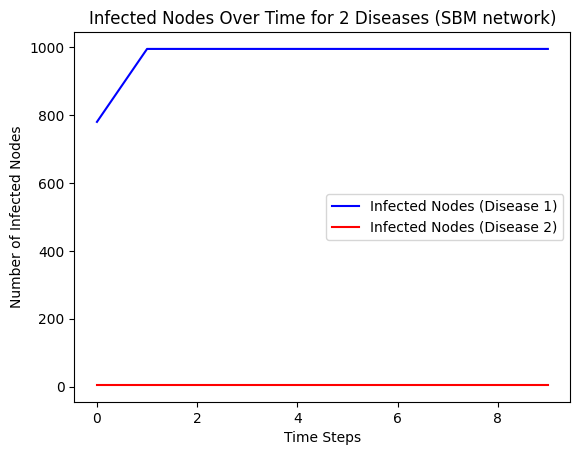

In [44]:
######################################## 8.3.2 ##############################################
def nodes_1(G):
    """
    Selects nodes for the beginning of the spread of disease 1.

    Args:
        G: a networkx graph

    Returns:
        a list of 5 nodes that belong to the same community and form a connected subgraph
    """
    
    
    
    while True:
        communities = set(nx.get_node_attributes(G, 'block').values())
        community = random.choice(list(communities))
        community_nodes = [n for n in G.nodes() if G.nodes[n]['block'] == community]
        if len(community_nodes) >=5 :
            start_node = random.choice(community_nodes)
            first_degree = [n for n in G.neighbors(start_node)]
            second_degree = [n for neighbour in first_degree for n in G.neighbors(neighbour) if G.nodes[n]['block'] == community]
            candidates = list(set(first_degree + second_degree) - {start_node})
            if len(candidates) >= 5:
                selected = random.sample(candidates,5)
                break
    
    return selected


def nodes_2(G, to_exclude):
    """
    Selects nodes for the beginning of the spread of disease 2.

    Args:
        G: a networkx graph
        to_exclude: a list containing the nodes to exclude from the selection, usually the nodes already chosen for the first disease

    Returns:
        a list of the 5 degrees with the highest degree that aren't already chosen for the first disease.
    """
    sorted_nodes = sorted(G.degree(), key = lambda x: x[1], reverse = True)
    top_nodes = [node for node, _ in sorted_nodes if node not in to_exclude]
    
    return top_nodes[:5]

random.seed(23)

sizes = [400, 300, 300]
probs = [[0.25, 0.05, 0.02], [0.05, 0.35, 0.07], [0.02, 0.07, 0.40]]
G = nx.stochastic_block_model(sizes, probs, seed=0)

threshold_1 = 0.02
threshold_2 = 0.02
initial_infected_nodes_1 = nodes_1(G)
initial_infected_nodes_2 = nodes_2(G, initial_infected_nodes_1)

# Check for nodes of the first disease and their degrees
print("Initial infected nodes for disease 1 (with degrees):")
for node in initial_infected_nodes_1:
    print(f"Node: {node}, Degree: {G.degree(node)}")

# Check for nodes of the second disease and their degrees
print("\nInitial infected nodes for disease 2 (with degrees):")
for node in initial_infected_nodes_2:
    print(f"Node: {node}, Degree: {G.degree(node)}")

graph, information_1, information_2 = Competitive_Linear_Threshold(G.copy(), initial_infected_nodes_1, initial_infected_nodes_2, threshold_1, threshold_2, 10)


# Check the list of infected nodes
# print("Information 1 (disease 1):", information_1)
# print("Information 2 (disease 2):", information_2)


plt.plot(range(len(information_1)), information_1, label='Infected Nodes (Disease 1)', color='blue')
plt.plot(range(len(information_2)), information_2, label='Infected Nodes (Disease 2)', color='red')
plt.xlabel("Time Steps")
plt.ylabel("Number of Infected Nodes")
plt.title("Infected Nodes Over Time for 2 Diseases (SBM network)")
plt.legend()
plt.show()
